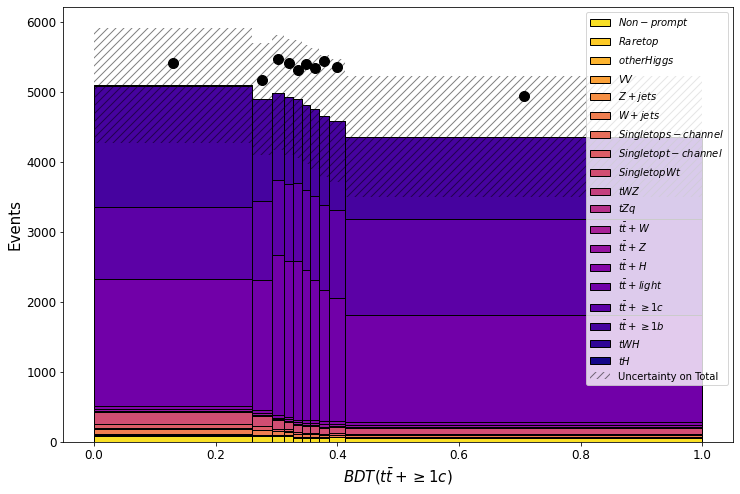

In [2]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os.path # to manipulate extension of file names (.yaml, .png etc.)

# file_name = "CR_ttb_prefit.yaml"
file_name = "CR_ttc_prefit.yaml"


with open(file_name, 'r') as stream:
    
    dictionary = yaml.full_load(stream)
    
    # convert string for proper LaTeX formatting when plotting    
    def latex_converter(input_obj):
        
        # to convert one string
        if isinstance(input_obj, str):
            return '$' + input_obj.replace('#', '\\') + '$'
        
        # to convert a df column
        else:
            return '$' + input_obj.replace('#', '\\\\', regex=True) + '$'

    # convert dictionaries into dfs
    samples_df = pd.DataFrame(dictionary['Samples'])
    total_df = pd.DataFrame(dictionary['Total']).T
    data_df = pd.DataFrame(dictionary['Data']).T
    figure_df = pd.DataFrame(dictionary['Figure']).T

    samples_df['Name'] = latex_converter(samples_df['Name'])
    samples_df.set_index('Name', inplace=True)
    # set column name of total_df and data_df to 'Yield' to match samples_df
    total_df.rename(columns={0:'Yield'}, inplace=True)
    data_df.rename(columns={0:'Yield'}, inplace=True)

    # merge them with multi-indexing
    result = pd.concat([samples_df, total_df, data_df], keys=['Samples', 'Total', 'Data'])

    
    """
    create centres and widths lists to be used in bar plots later
    """
    bin_edges = figure_df.iloc[0][0]
    centres = []
    widths = []

    for i, val in enumerate(bin_edges):
        try:
            x = val # current value
            y = bin_edges[i+1] # next value
            diff = y - x
            widths.append(diff)
            centres.append(x + 0.5*(diff))
        except:
            continue
    
    # 0.5*(edges[1:] + edges[:-1]) gives bin centres preventing double count

    """
    create custom color list for bar plot
    """
    source = result.loc[['Samples']] # list of units to be stacked
    pct_max = 99 # for example, max percentile of color ramp
    pct_min = 1 # for example, min percentile of color ramp
    ramp = plt.cm.plasma

    # number of items in data source
    n = len(source)

    # list of values between 0.00 and 1.00; length equals length of data source
    n_prop = list(i / 100.0 for i in (np.arange(pct_min, pct_max, (pct_max-pct_min)/n)))

    # create list of colors
    color_list = []
    for i in n_prop:
        clr = ramp(i) 
        color_list.append(clr)


    """
    bar plot
    """
    fig, ax = plt.subplots(figsize=(12,8))
    
    # create stacked bar plot for each row in df 'Yield' column
    sum_list = [0]*10
    for i, row in reversed(list(enumerate(result['Yield']))):
        if result.index[i][0] == 'Samples':
            ax.bar(centres, row, width=widths, bottom=sum_list, label=result.index[i][1], edgecolor='k', color=color_list[i])
            sum_list = [sum(a) for a in zip(sum_list, row)]

    ax.scatter(centres, result.loc[['Data']].iloc[0,0], color='k', s=100) # real data points

    total_bars = result.loc[['Total']].iloc[0,0] # heiht of all bars summed up
    ax.bar(centres, result.loc[['Total']].iloc[1,0], width=widths, bottom=total_bars, fill=False, linewidth=0, alpha=0.5, hatch='///', label="Uncertainty on Total")
    ax.bar(centres, result.loc[['Total']].iloc[2,0], width=widths, bottom=total_bars, fill=False, linewidth=0, alpha=0.5, hatch='///')
    ax.legend()
    
    xlabel = latex_converter(figure_df.iloc[1,0])
    ax.set_xlabel(xlabel, fontsize=15)
    ax.set_ylabel("Events", fontsize=15)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    newname = os.path.splitext(file_name)[0] + '.png' # or save as .eps for latex plots
    fig.savefig(newname, facecolor='white', transparent=False, dpi=1200)